<a href="https://colab.research.google.com/github/wongledongle/liftempo/blob/main/liftempovisual1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install scipy

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)


In [29]:
CSV_PATH = "/content/liftempo_sessions_2.csv"

df = pd.read_csv(CSV_PATH)
df.head()


,session_id,session_date,sample_index,timestamp,rotX,rotY,rotZ,accX,accY,accZ
0,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,0,1.765855e+09,0.130125,0.020638,-0.105609,-0.043743,0.102632,-0.034769
1,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,1,1.765855e+09,0.044633,-0.091622,0.002189,0.048786,-0.020863,-0.046658
2,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,2,1.765855e+09,-0.053888,-0.046635,0.062859,-0.019219,-0.035935,-0.031313
3,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,3,1.765855e+09,0.040757,-0.037635,0.022130,-0.017326,0.017241,-0.030660
4,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,4,1.765855e+09,0.062631,-0.080817,-0.011351,0.025298,0.016426,-0.027056


In [30]:
# Basic structure
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
display(df.info())

# How many distinct sessions?
session_ids = df["session_id"].unique()
print("\nNumber of sessions:", len(session_ids))
print("Session IDs:", session_ids)

# Samples per session
samples_per_session = df.groupby("session_id")["sample_index"].max() + 1
print("\nSamples per session:")
display(samples_per_session)


Shape: (465, 10)

Columns: ['session_id', 'session_date', 'sample_index', 'timestamp', 'rotX', 'rotY', 'rotZ', 'accX', 'accY', 'accZ']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   session_id    465 non-null    object 
 1   session_date  465 non-null    object 
 2   sample_index  465 non-null    int64  
 3   timestamp     465 non-null    float64
 4   rotX          465 non-null    float64
 5   rotY          465 non-null    float64
 6   rotZ          465 non-null    float64
 7   accX          465 non-null    float64
 8   accY          465 non-null    float64
 9   accZ          465 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 36.5+ KB


None


Number of sessions: 1
Session IDs: ['AC3E7102-65EC-42C3-8782-F5C235F29E3A']

Samples per session:


,sample_index
session_id,
AC3E7102-65EC-42C3-8782-F5C235F29E3A,465


In [31]:
# Pick a session to inspect (0 = first one)
session_idx = 0
session_id = session_ids[session_idx]
print("Inspecting session:", session_id)

session_df = (
    df[df["session_id"] == session_id]
    .sort_values("sample_index")
    .reset_index(drop=True)
)

# Create relative time in seconds (start at 0)
t0 = session_df["timestamp"].min()
session_df["t_rel"] = session_df["timestamp"] - t0

session_df.head()


Inspecting session: AC3E7102-65EC-42C3-8782-F5C235F29E3A


,session_id,session_date,sample_index,timestamp,rotX,rotY,rotZ,accX,accY,accZ,t_rel
0,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,0,1.765855e+09,0.130125,0.020638,-0.105609,-0.043743,0.102632,-0.034769,0.000000
1,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,1,1.765855e+09,0.044633,-0.091622,0.002189,0.048786,-0.020863,-0.046658,0.003857
2,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,2,1.765855e+09,-0.053888,-0.046635,0.062859,-0.019219,-0.035935,-0.031313,0.023706
3,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,3,1.765855e+09,0.040757,-0.037635,0.022130,-0.017326,0.017241,-0.030660,0.043695
4,AC3E7102-65EC-42C3-8782-F5C235F29E3A,2025-12-16T03:15:36.222Z,4,1.765855e+09,0.062631,-0.080817,-0.011351,0.025298,0.016426,-0.027056,0.064148


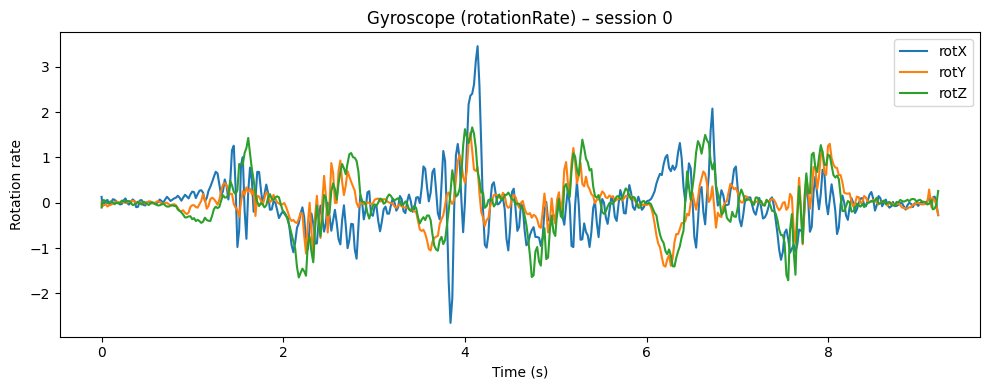

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(session_df["t_rel"], session_df["rotX"], label="rotX")
plt.plot(session_df["t_rel"], session_df["rotY"], label="rotY")
plt.plot(session_df["t_rel"], session_df["rotZ"], label="rotZ")
plt.xlabel("Time (s)")
plt.ylabel("Rotation rate")
plt.title(f"Gyroscope (rotationRate) – session {session_idx}")
plt.legend()
plt.tight_layout()
plt.show()


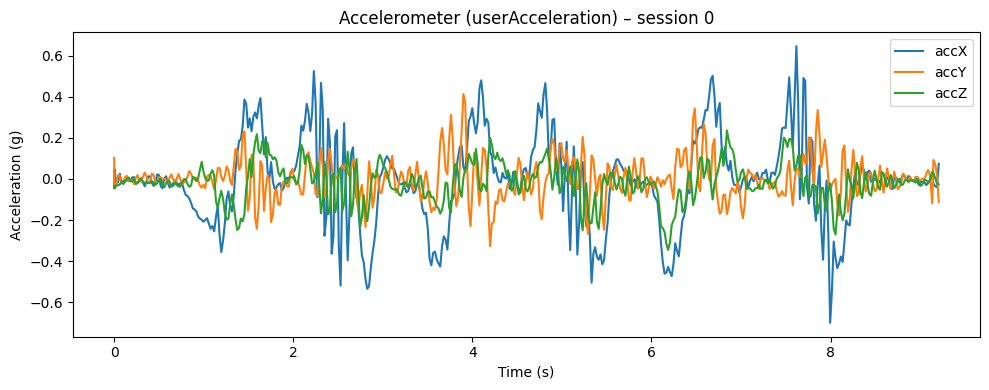

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(session_df["t_rel"], session_df["accX"], label="accX")
plt.plot(session_df["t_rel"], session_df["accY"], label="accY")
plt.plot(session_df["t_rel"], session_df["accZ"], label="accZ")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.title(f"Accelerometer (userAcceleration) – session {session_idx}")
plt.legend()
plt.tight_layout()
plt.show()


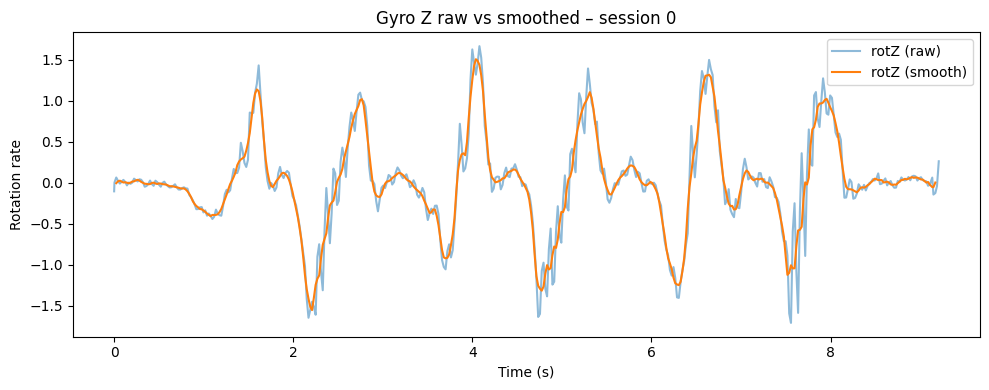

In [34]:
# Simple moving average smoothing
window = 5  # adjust (in samples); at 50 Hz, 5 samples ~0.1s
for col in ["rotX", "rotY", "rotZ"]:
    session_df[col + "_smooth"] = session_df[col].rolling(window, center=True).mean()

plt.figure(figsize=(10, 4))
plt.plot(session_df["t_rel"], session_df["rotZ"], label="rotZ (raw)", alpha=0.5)
plt.plot(session_df["t_rel"], session_df["rotZ_smooth"], label="rotZ (smooth)")
plt.xlabel("Time (s)")
plt.ylabel("Rotation rate")
plt.title(f"Gyro Z raw vs smoothed – session {session_idx}")
plt.legend()
plt.tight_layout()
plt.show()


Number of candidate movement samples: 96


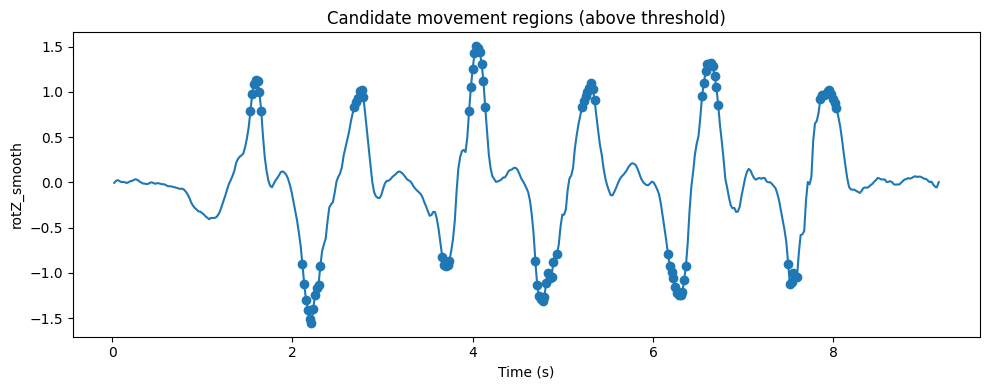

In [35]:
# Example: look at peaks on the smoothed rotZ signal
signal = session_df["rotZ_smooth"].to_numpy()
time = session_df["t_rel"].to_numpy()

# Example threshold: magnitude above which we consider "interesting movement"
threshold = np.nanmean(np.abs(signal)) + np.nanstd(np.abs(signal))

candidate_indices = np.where(np.abs(signal) > threshold)[0]
candidate_times = time[candidate_indices]

print("Number of candidate movement samples:", len(candidate_indices))

plt.figure(figsize=(10, 4))
plt.plot(time, signal)
plt.scatter(candidate_times, signal[candidate_indices], marker="o")
plt.xlabel("Time (s)")
plt.ylabel("rotZ_smooth")
plt.title("Candidate movement regions (above threshold)")
plt.tight_layout()
plt.show()


rep detection module

In [40]:
import numpy as np
def dominant_axis(session_df):
    # Compute variance of each axis to pick the dominant movement signal.
    vars = {
        "rotX": session_df["rotX"].var(),
        "rotY": session_df["rotY"].var(),
        "rotZ": session_df["rotZ"].var(),
    }
    axis = max(vars, key=vars.get)
    print("Dominant axis:", axis)
    return axis

def smooth_signal(signal, window=7):
    return pd.Series(signal).rolling(window, center=True).mean().to_numpy()

def compute_sign(signal):
    # Simple derivative
    vel = np.diff(signal, prepend=signal[0])
    sign = np.sign(vel)
    return sign

def zero_crossings(sign):
    # Positions where sign changes from + to - or - to +
    zc = np.where(np.diff(sign) != 0)[0]
    return zc

def filter_by_magnitude(signal, zc_indices, mag_threshold):
    return [i for i in zc_indices if abs(signal[i]) > mag_threshold]


def detect_reps(session_df, axis=None, smooth_window=9,
                   mag_thresh_factor=1.0,
                   min_rep_time=0.8,
                   min_phase_time=0.2):
    """
    Heuristic rep detector for bench press.

    - min_rep_time: minimum total duration of a rep (seconds)
    - min_phase_time: minimum time between eccentric/concentric boundaries
    """

    # 1. choose axis
    if axis is None:
        axis = dominant_axis(session_df)

    raw = session_df[axis].to_numpy()
    t = session_df["t_rel"].to_numpy()

    # 2. smooth
    smooth = smooth_signal(raw, window=smooth_window)

    # 3. movement sign
    sign = compute_sign(smooth)

    # 4. zero-crossings
    zc = zero_crossings(sign)

    # 5. magnitude-based filter
    mag_threshold = np.nanstd(smooth) * mag_thresh_factor
    zc = [i for i in zc if abs(smooth[i]) > mag_threshold]

    # 6. TIME-BASED FILTERING (this fixes YOUR problem)
    filtered = []
    last_time = -999

    for idx in zc:
        if t[idx] - last_time >= min_phase_time:  # ignore micro-jitter
            filtered.append(idx)
            last_time = t[idx]

    # 7. Now group zero-crossings into reps
    reps = []
    i = 0
    while i < len(filtered) - 2:
        start = filtered[i]
        bottom = filtered[i + 1]
        end = filtered[i + 2]

        # ensure realistic rep timing
        if (t[end] - t[start]) >= min_rep_time:
            reps.append({
                "start_idx": start,
                "bottom_idx": bottom,
                "end_idx": end,
                "eccentric_duration": t[bottom] - t[start],
                "concentric_duration": t[end] - t[bottom],
            })

            i += 3  # skip ahead to next rep
        else:
            i += 1

    print(f"Detected reps: {len(reps)}")
    return reps, smooth, filtered


In [39]:
import matplotlib.pyplot as plt

def plot_reps(session_df, smoothed, reps):
    t = session_df["t_rel"].to_numpy()

    plt.figure(figsize=(12, 4))
    plt.plot(t, smoothed, label="smoothed")

    for rep in reps:
        # Mark start, bottom, end
        plt.axvline(t[rep["start_idx"]], linestyle='--')
        plt.axvline(t[rep["bottom_idx"]], linestyle='--')
        plt.axvline(t[rep["end_idx"]], linestyle='--')

    plt.title("Rep Detection Boundaries")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.show()


Dominant axis: rotX
Detected reps: 3


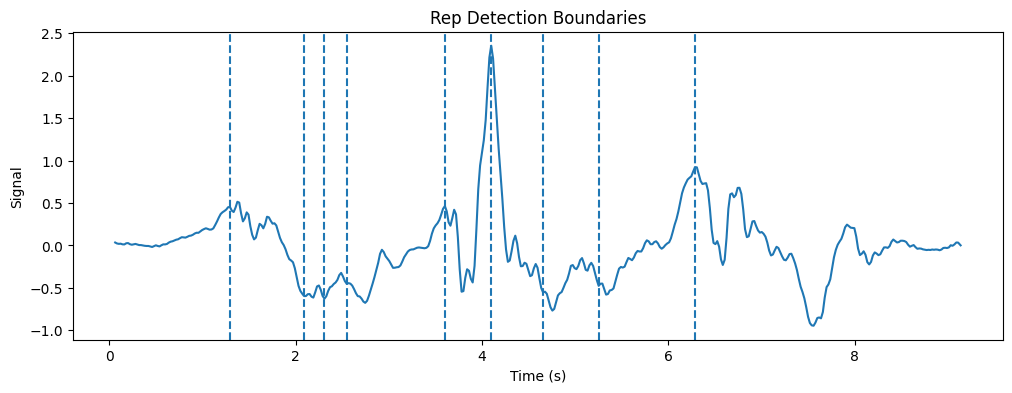

[{'start_idx': np.int64(66),
  'bottom_idx': np.int64(106),
  'end_idx': np.int64(117),
  'eccentric_duration': np.float64(0.7951638698577881),
  'concentric_duration': np.float64(0.21873211860656738)},
 {'start_idx': np.int64(129),
  'bottom_idx': np.int64(182),
  'end_idx': np.int64(207),
  'eccentric_duration': np.float64(1.0536408424377441),
  'concentric_duration': np.float64(0.49710893630981445)},
 {'start_idx': np.int64(235),
  'bottom_idx': np.int64(265),
  'end_idx': np.int64(317),
  'eccentric_duration': np.float64(0.5963611602783203),
  'concentric_duration': np.float64(1.0338678359985352)}]

In [41]:
reps, smooth, filtered = detect_reps(session_df)
plot_reps(session_df, smooth, reps)
reps

In [57]:
from scipy.signal import find_peaks

def detect_reps_v5(session_df, axis=None, smooth_window=13):
    if axis is None:
        axis = dominant_axis(session_df)

    raw = session_df[axis].to_numpy()
    t = session_df["t_rel"].to_numpy()

    # smoother signal
    smooth = smooth_signal(raw, window=smooth_window)

    # --- TUNED PEAK DETECTION ---
    peaks, _ = find_peaks(
        smooth,
        height=0.55,         # ↓ smaller threshold so rep 3's peak is included
        distance=50,         # ↓ allow rep 3 to be detected
        prominence=0.25      # ↓ lower prominence because rep 3 is softer
    )

    # --- TUNED VALLEY DETECTION ---
    valleys, _ = find_peaks(
        -smooth,
        height=0.35,         # ↓ valley depth threshold
        distance=50,
        prominence=0.25
    )

    # pair valleys → peaks
    reps = []
    p = 0
    for v in valleys:
        while p < len(peaks) and peaks[p] < v:
            p += 1
        if p >= len(peaks):
            break
        peak = peaks[p]

        # ensure timing makes sense
        if (t[peak] - t[v]) > 0.4:   # rep must last at least 0.4 sec
            reps.append({
                "valley_idx": int(v),
                "peak_idx": int(peak),
                "ecc_time": float(t[v] - t[v-1]) if v > 0 else None,
                "con_time": float(t[peak] - t[v])
            })

    print("Detected reps:", len(reps))
    return reps, smooth, peaks, valleys


In [51]:
def plot_reps_peak_valley(session_df, smooth, peaks, valleys):
    t = session_df["t_rel"].to_numpy()

    plt.figure(figsize=(12, 4))
    plt.plot(t, smooth, label="smoothed")

    plt.scatter(t[peaks], smooth[peaks], c='red', label='peaks')
    plt.scatter(t[valleys], smooth[valleys], c='blue', label='valleys')

    plt.title("Peak/Valley Rep Detection")
    plt.legend()
    plt.show()


Dominant axis: rotX
Detected reps: 2


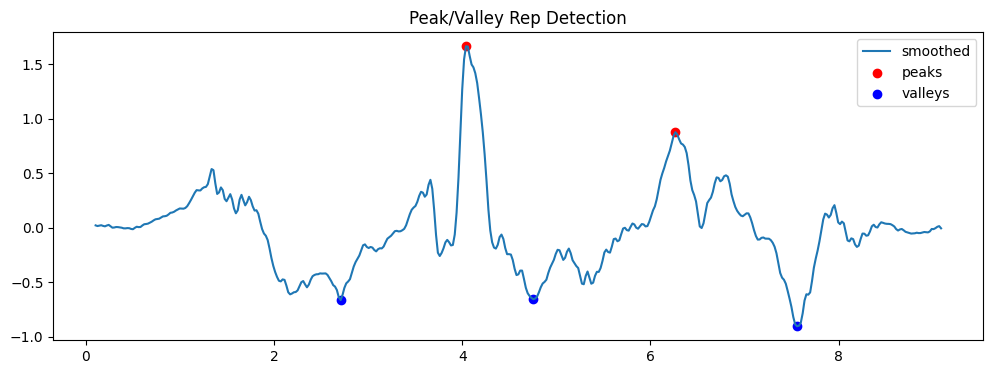

[{'valley_idx': 137,
  'peak_idx': 204,
  'ecc_time': 0.020075321197509766,
  'con_time': 1.3322808742523193},
 {'valley_idx': 240,
  'peak_idx': 316,
  'ecc_time': 0.01983785629272461,
  'con_time': 1.5108418464660645}]

In [58]:
reps, smooth, peaks, valleys = detect_reps_v5(session_df)
plot_reps_peak_valley(session_df, smooth, peaks, valleys)
reps
